In [18]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from sklearn import mixture

from pathlib import Path
import torch
import h5py
import tqdm
from IPython.display import Audio, display

import sys
sys.path += ['../music-translation/src']

import utils
import wavenet_models
from utils import save_audio
from wavenet import WaveNet
from wavenet_generator import WavenetGenerator
from nv_wavenet_generator import NVWavenetGenerator
from nv_wavenet_generator import Impl

In [8]:
encoded = []
for directory in Path('encoded-musicnet/encoded').iterdir():
    for path in directory.iterdir():
        encoded += [torch.load(path)]
encoded = torch.cat(encoded, dim=0)
flattened = torch.flatten(encoded, 1)
flattened = flattened.cpu().numpy()
print(flattened.shape)

(203, 12800)


In [9]:
#choosing model

lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type, reg_covar = 1e-4)
        gmm.fit(flattened)
        bic.append(gmm.bic(flattened))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [10]:
print(best_gmm.get_params())

{'covariance_type': 'diag', 'init_params': 'kmeans', 'max_iter': 100, 'means_init': None, 'n_components': 6, 'n_init': 1, 'precisions_init': None, 'random_state': None, 'reg_covar': 0.0001, 'tol': 0.001, 'verbose': 0, 'verbose_interval': 10, 'warm_start': False, 'weights_init': None}


In [28]:
samples = []
for i in range(4):
    samples += [torch.from_numpy(best_gmm.sample()[0].reshape(1, 64, 200))]

In [12]:
checkpoint = Path('../music-translation/checkpoints/pretrained_musicnet/bestmodel')
decoders = [0, 1, 2, 3, 4, 5]
batch_size = 1
rate = 16000
split_size = 20



def disp(x, decoder_ix):
    wav = utils.inv_mu_law(x.cpu().numpy())
    print(f'Decoder: {decoder_ix}')
    print(f'X min: {x.min()}, max: {x.max()}')

    display(Audio(wav.squeeze(), rate=rate))
        
def extract_id(path):
    decoder_id = str(path)[:-4].split('_')[-1]
    return int(decoder_id)



print('Starting')
matplotlib.use('agg')

checkpoints = checkpoint.parent.glob(checkpoint.name + '_*.pth')
checkpoints = [c for c in checkpoints if extract_id(c) in decoders]
assert len(checkpoints) >= 1, "No checkpoints found."

model_args = torch.load(checkpoint.parent / 'args.pth')[0]

decoders = []
decoder_ids = []
for checkpoint in checkpoints:
    decoder = WaveNet(model_args)
    decoder.load_state_dict(torch.load(checkpoint)['decoder_state'])
    decoder.eval()
    decoder = decoder.cuda()
    decoder = WavenetGenerator(decoder, batch_size, wav_freq=rate)
    
    decoders += [decoder]
    decoder_ids += [extract_id(checkpoint)]

Starting


In [ ]:
#decoding randomly generated vectors

yy = {}
with torch.no_grad():
    zz = []
    for vector in samples:
        zz += [vector]
    zz = torch.cat(zz, dim=0).float().cuda()
    print(zz.shape)

    with utils.timeit("Generation timer"):
        for i, decoder_id in enumerate(decoder_ids):
            if decoder_id != 3:
                continue
            yy[decoder_id] = []
            decoder = decoders[i]
            for zz_batch in torch.split(zz, batch_size):
                print(zz_batch.shape)
                splits = torch.split(zz_batch, split_size, -1)
                audio_data = []
                decoder.reset()
                for cond in tqdm.tqdm_notebook(splits):
                    audio_data += [decoder.generate(cond).cpu()]
                audio_data = torch.cat(audio_data, -1)
                yy[decoder_id] += [audio_data]
            yy[decoder_id] = torch.cat(yy[decoder_id], dim=0)

torch.Size([4, 64, 200])
torch.Size([1, 64, 200])


/home/wangjim19/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Generating:   0%|          | 0/20 [00:00<?, ?it/s]

Generating:   5%|▌         | 1/20 [00:27<08:46, 27.70s/it]

Generating:  10%|█         | 2/20 [00:55<08:17, 27.64s/it]

Generating:  15%|█▌        | 3/20 [01:22<07:49, 27.59s/it]

Generating:  20%|██        | 4/20 [01:50<07:20, 27.55s/it]

Generating:  25%|██▌       | 5/20 [02:17<06:53, 27.58s/it]

Generating:  30%|███       | 6/20 [02:45<06:26, 27.58s/it]

Generating:  35%|███▌      | 7/20 [03:13<05:58, 27.61s/it]

Generating:  40%|████      | 8/20 [03:40<05:31, 27.66s/it]

Generating:  45%|████▌     | 9/20 [04:08<05:04, 27.69s/it]

Generating:  50%|█████     | 10/20 [04:36<04:37, 27.76s/it]

Generating:  55%|█████▌    | 11/20 [05:04<04:09, 27.72s/it]

Generating:  60%|██████    | 12/20 [05:31<03:41, 27.67s/it]

Generating:  65%|██████▌   | 13/20 [05:59<03:13, 27.60s/it]

Generating:  70%|███████   | 14/20 [06:26<02:45, 27.56s/it]

Generating:  75%|███████▌  | 15/20 [06:57<02:22, 28.43s/it]

Generating:  80%|████████  | 16/20 [07:2

Generating: 100%|██████████| 20/20 [10:29<00:00, 31.46s/it]


Generating:   0%|          | 0/20 [00:00<?, ?it/s]

Generating:   5%|▌         | 1/20 [00:31<09:57, 31.44s/it]

Generating:  10%|█         | 2/20 [01:02<09:25, 31.44s/it]

Generating:  15%|█▌        | 3/20 [01:34<08:54, 31.45s/it]

Generating:  20%|██        | 4/20 [02:05<08:23, 31.47s/it]

Generating:  25%|██▌       | 5/20 [02:37<07:52, 31.47s/it]

Generating:  30%|███       | 6/20 [03:08<07:20, 31.46s/it]

Generating:  35%|███▌      | 7/20 [03:40<06:49, 31.46s/it]

Generating:  40%|████      | 8/20 [04:11<06:17, 31.47s/it]

Generating:  45%|████▌     | 9/20 [04:43<05:46, 31.47s/it]

Generating:  50%|█████     | 10/20 [05:14<05:14, 31.47s/it]

Generating:  55%|█████▌    | 11/20 [05:46<04:43, 31.47s/it]

Generating:  60%|██████    | 12/20 [06:17<04:11, 31.47s/it]

Generating:  65%|██████▌   | 13/20 [06:49<03:40, 31.47s/it]

Generating:  70%|███████   | 14/20 [07:20<03:08, 31.48s/it]

Generating:  75%|███████▌  | 15/20 [07:52


torch.Size([1, 64, 200])




Generating:   0%|          | 0/20 [00:00<?, ?it/s]

Generating:   5%|▌         | 1/20 [00:31<09:57, 31.47s/it]

Generating:  10%|█         | 2/20 [01:02<09:26, 31.48s/it]

Generating:  15%|█▌        | 3/20 [01:34<08:55, 31.48s/it]

Generating:  20%|██        | 4/20 [02:05<08:23, 31.48s/it]

Generating:  25%|██▌       | 5/20 [02:37<07:52, 31.47s/it]

Generating:  30%|███       | 6/20 [03:08<07:20, 31.47s/it]

Generating:  35%|███▌      | 7/20 [03:40<06:49, 31.47s/it]

Generating:  40%|████      | 8/20 [04:11<06:17, 31.48s/it]

Generating:  45%|████▌     | 9/20 [04:43<05:46, 31.49s/it]

Generating:  50%|█████     | 10/20 [05:14<05:14, 31.48s/it]

Generating:  55%|█████▌    | 11/20 [05:46<04:43, 31.47s/it]

Generating:  60%|██████    | 12/20 [06:17<04:11, 31.46s/it]

Generating:  65%|██████▌   | 13/20 [06:49<03:40, 31.47s/it]

Generating:  70%|███████   | 14/20 [07:20<03:08, 31.48s/it]

Generating:  75%|███████▌  | 15/20 [07:52<02:37, 31.48s/it]

Generating:  80%|████████  | 16/20 [08:2

Generating:  90%|█████████ | 18/20 [09:06<00:59, 29.78s/it]

Generating:  95%|█████████▌| 19/20 [09:38<00:30, 30.23s/it]

Generating: 100%|██████████| 20/20 [10:09<00:00, 30.48s/it]


Generating:   0%|          | 0/20 [00:00<?, ?it/s]

Generating:   5%|▌         | 1/20 [00:31<09:52, 31.20s/it]

Generating:  10%|█         | 2/20 [01:02<09:21, 31.20s/it]

Generating:  15%|█▌        | 3/20 [01:33<08:50, 31.22s/it]

Generating:  20%|██        | 4/20 [02:04<08:19, 31.22s/it]

Generating:  25%|██▌       | 5/20 [02:36<07:48, 31.21s/it]

Generating:  30%|███       | 6/20 [03:07<07:17, 31.23s/it]

Generating:  35%|███▌      | 7/20 [03:37<06:42, 30.96s/it]

Generating:  40%|████      | 8/20 [04:07<06:08, 30.70s/it]

Generating:  45%|████▌     | 9/20 [04:37<05:35, 30.49s/it]

Generating:  50%|█████     | 10/20 [05:07<05:03, 30.38s/it]

Generating:  55%|█████▌    | 11/20 [05:37<04:32, 30.27s/it]

Generating:  60%|██████    | 12/20 [06:09<04:04, 30.58s/it]

Generating:  65%|██████▌   | 13/20 [06:40


torch.Size([1, 64, 200])




Generating:   0%|          | 0/20 [00:00<?, ?it/s]

Generating:   5%|▌         | 1/20 [00:31<09:53, 31.23s/it]

Generating:  10%|█         | 2/20 [01:02<09:22, 31.24s/it]

Generating:  15%|█▌        | 3/20 [01:33<08:51, 31.25s/it]

Generating:  20%|██        | 4/20 [02:05<08:20, 31.27s/it]

Generating:  25%|██▌       | 5/20 [02:36<07:49, 31.27s/it]

Generating:  30%|███       | 6/20 [03:07<07:18, 31.30s/it]

Generating:  35%|███▌      | 7/20 [03:39<06:46, 31.30s/it]

Generating:  40%|████      | 8/20 [04:10<06:16, 31.34s/it]

Generating:  45%|████▌     | 9/20 [04:41<05:44, 31.36s/it]

Generating:  50%|█████     | 10/20 [05:13<05:13, 31.37s/it]

Generating:  55%|█████▌    | 11/20 [05:44<04:42, 31.38s/it]

Generating:  60%|██████    | 12/20 [06:16<04:11, 31.42s/it]

Generating:  65%|██████▌   | 13/20 [06:47<03:39, 31.42s/it]

Generating:  70%|███████   | 14/20 [07:19<03:08, 31.44s/it]

Generating:  75%|███████▌  | 15/20 [07:50<02:37, 31.45s/it]

Generating:  80%|████████  | 16/20 [08:2

Generating:  90%|█████████ | 18/20 [09:21<01:02, 31.35s/it]

Generating:  95%|█████████▌| 19/20 [09:53<00:31, 31.34s/it]

Generating: 100%|██████████| 20/20 [10:24<00:00, 31.23s/it]


Generating:   0%|          | 0/20 [00:00<?, ?it/s]

Generating:   5%|▌         | 1/20 [00:31<09:53, 31.23s/it]

Generating:  10%|█         | 2/20 [01:02<09:23, 31.30s/it]

Generating:  15%|█▌        | 3/20 [01:34<08:52, 31.31s/it]

Generating:  20%|██        | 4/20 [02:05<08:21, 31.33s/it]

Generating:  25%|██▌       | 5/20 [02:36<07:49, 31.33s/it]

Generating:  30%|███       | 6/20 [03:08<07:18, 31.33s/it]

Generating:  35%|███▌      | 7/20 [03:39<06:47, 31.34s/it]

Generating:  40%|████      | 8/20 [04:10<06:16, 31.34s/it]

Generating:  45%|████▌     | 9/20 [04:42<05:44, 31.34s/it]

Generating:  50%|█████     | 10/20 [05:13<05:13, 31.34s/it]

Generating:  55%|█████▌    | 11/20 [05:44<04:42, 31.34s/it]

Generating:  60%|██████    | 12/20 [06:16<04:10, 31.35s/it]

Generating:  65%|██████▌   | 13/20 [06:47


torch.Size([1, 64, 200])




Generating:   0%|          | 0/20 [00:00<?, ?it/s]

Generating:   5%|▌         | 1/20 [00:31<09:55, 31.34s/it]

Generating:  10%|█         | 2/20 [01:02<09:24, 31.34s/it]

Generating:  15%|█▌        | 3/20 [01:34<08:52, 31.34s/it]

Generating:  20%|██        | 4/20 [02:05<08:21, 31.35s/it]

Generating:  25%|██▌       | 5/20 [02:36<07:50, 31.36s/it]

Generating:  30%|███       | 6/20 [03:08<07:18, 31.35s/it]

Generating:  35%|███▌      | 7/20 [03:39<06:47, 31.33s/it]

Generating:  40%|████      | 8/20 [04:10<06:15, 31.32s/it]

Generating:  45%|████▌     | 9/20 [04:41<05:44, 31.29s/it]

Generating:  50%|█████     | 10/20 [05:13<05:12, 31.28s/it]

Generating:  55%|█████▌    | 11/20 [05:44<04:41, 31.30s/it]

Generating:  60%|██████    | 12/20 [06:15<04:10, 31.33s/it]

Generating:  65%|██████▌   | 13/20 [06:47<03:39, 31.33s/it]

Generating:  70%|███████   | 14/20 [07:18<03:08, 31.35s/it]

Generating:  75%|███████▌  | 15/20 [07:50<02:36, 31.37s/it]

Generating:  80%|████████  | 16/20 [08:2

Generating:  90%|█████████ | 18/20 [09:24<01:02, 31.44s/it]

Generating:  95%|█████████▌| 19/20 [09:56<00:31, 31.44s/it]

Generating: 100%|██████████| 20/20 [10:26<00:00, 31.35s/it]


Generating:   0%|          | 0/20 [00:00<?, ?it/s]

Generating:   5%|▌         | 1/20 [00:29<09:20, 29.49s/it]

Generating:  10%|█         | 2/20 [00:59<08:51, 29.53s/it]

Generating:  15%|█▌        | 3/20 [01:28<08:22, 29.55s/it]

Generating:  20%|██        | 4/20 [01:58<07:53, 29.57s/it]

Generating:  25%|██▌       | 5/20 [02:27<07:23, 29.56s/it]

Generating:  30%|███       | 6/20 [02:57<06:52, 29.45s/it]

Generating:  35%|███▌      | 7/20 [03:26<06:22, 29.44s/it]

Generating:  40%|████      | 8/20 [03:56<05:55, 29.66s/it]

Generating:  45%|████▌     | 9/20 [04:28<05:32, 30.20s/it]

Generating:  50%|█████     | 10/20 [04:59<05:05, 30.57s/it]

Generating:  55%|█████▌    | 11/20 [05:30<04:37, 30.83s/it]

Generating:  60%|██████    | 12/20 [06:02<04:08, 31.03s/it]

Generating:  65%|██████▌   | 13/20 [06:33

In [ ]:
for decoder_ix, decoder_result in yy.items():
    i=0
    for sample_result, sample in zip(decoder_result, samples):
        disp(sample_result, decoder_ix)
        wav = utils.inv_mu_law(sample_result.cpu().numpy())
        
        component = best_gmm.predict(sample.reshape(1,12800))[0]
        print(component)
        save_audio(wav.squeeze(), Path("results/gmm" + str(component) + '-' + str(i) + "_d" + str(decoder_ix) + ".wav"), rate)
        i+=1

In [14]:
components = {}
for directory in Path('encoded-musicnet/encoded').iterdir():
    components[directory.name.replace('_', ' ')] = [0, 0, 0, 0, 0, 0]
    for path in directory.iterdir():
        component = best_gmm.predict(torch.flatten(torch.load(path), 1).cpu().numpy())[0]
        components[directory.name.replace('_', ' ')][component] += 1
print(components)

{'Beethoven Accompanied Violin': [0, 6, 0, 9, 7, 0], 'Bach Solo Cello': [0, 8, 0, 2, 2, 0], 'Bach Solo Piano': [0, 16, 0, 5, 18, 0], 'Beethoven Solo Piano': [34, 6, 17, 8, 8, 20], 'Beethoven String Quartet': [0, 12, 0, 10, 5, 1], 'Cambini Wind Quintet': [0, 4, 0, 2, 2, 1]}


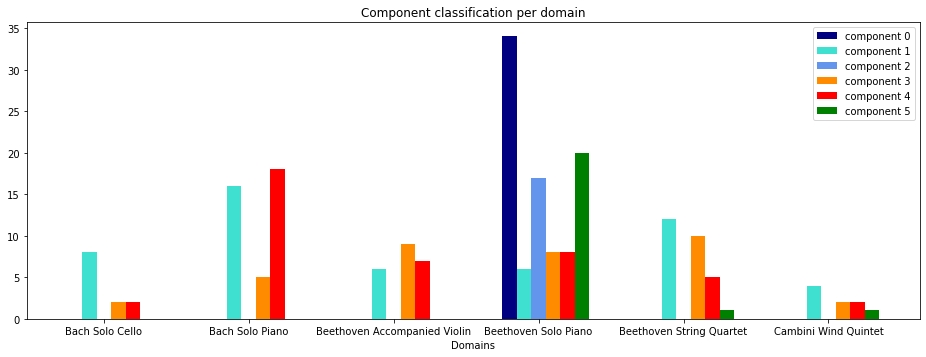

In [20]:
n_components_range = range(1, 7)

color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange', 'red', 'green'])
distributions = ['component 0', 'component 1', 'component 2', 'component 3', 'component 4', 'component 5']
bars = []
keys = ['Bach Solo Cello', 'Bach Solo Piano', 'Beethoven Accompanied Violin', 'Beethoven Solo Piano', 'Beethoven String Quartet', 'Cambini Wind Quintet']

plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (component, color) in enumerate(zip(distributions, color_iter)):
    xpos = np.array(n_components_range) + .1 * (i - 2)
    bars.append(plt.bar(xpos, [components[key][i] for key in keys],
                        width=.1, color=color))
plt.xticks(n_components_range, labels = keys)
plt.title('Component classification per domain')
spl.set_xlabel('Domains')
spl.legend(distributions)

In [25]:
means = torch.from_numpy(best_gmm.means_).reshape(-1, 64, 200)
print(means)

tensor([[[ 2.0316e-01,  2.7503e-01,  2.6434e-01,  ..., -8.9135e-03,
          -1.9641e-02, -3.1639e-02],
         [-7.1262e-01, -8.0323e-01, -8.0264e-01,  ..., -1.5254e-01,
          -1.5919e-01, -1.3404e-01],
         [ 9.7455e-02,  1.5963e-01,  1.6231e-01,  ..., -1.5372e-02,
          -2.0790e-02, -9.5187e-03],
         ...,
         [-2.8117e-01, -3.0853e-01, -2.9737e-01,  ...,  5.0782e-02,
           6.5404e-02,  6.1124e-02],
         [ 1.0191e-01,  1.8918e-01,  1.9050e-01,  ...,  5.7227e-03,
           1.4061e-02,  1.3072e-02],
         [-7.0619e-02, -8.2851e-03,  1.3233e-02,  ...,  3.5174e-02,
           3.8658e-02,  3.5657e-02]],

        [[ 8.2628e-02,  1.0367e-01,  8.4945e-02,  ..., -3.3411e-02,
          -3.1236e-02, -4.7554e-02],
         [-6.0101e-01, -5.8798e-01, -5.6199e-01,  ...,  9.1959e-02,
           1.0039e-01,  7.9012e-02],
         [ 6.3511e-05,  3.9634e-02,  4.0825e-02,  ..., -3.0159e-02,
          -1.9378e-02, -1.6274e-02],
         ...,
         [-2.0642e-01, -2

In [23]:
#decoding means of gmm components

yy = {}
with torch.no_grad():
    zz = means.float().cuda()

    with utils.timeit("Generation timer"):
        for i, decoder_id in enumerate(decoder_ids):
            if decoder_id != 3:
                continue
            yy[decoder_id] = []
            decoder = decoders[i]
            for zz_batch in torch.split(zz, batch_size):
                print(zz_batch.shape)
                splits = torch.split(zz_batch, split_size, -1)
                audio_data = []
                decoder.reset()
                for cond in tqdm.tqdm_notebook(splits):
                    audio_data += [decoder.generate(cond).cpu()]
                audio_data = torch.cat(audio_data, -1)
                yy[decoder_id] += [audio_data]
            yy[decoder_id] = torch.cat(yy[decoder_id], dim=0)

torch.Size([1, 64, 200])


/home/wangjim19/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Generating: 100%|██████████| 20/20 [10:40<00:00, 32.02s/it]

Generating: 100%|██████████| 20/20 [10:38<00:00, 31.91s/it]

Generating: 100%|██████████| 20/20 [10:28<00:00, 31.43s/it]

Generating: 100%|██████████| 20/20 [10:31<00:00, 31.56s/it]

Generating: 100%|██████████| 20/20 [10:30<00:00, 31.52s/it]

Generating: 100%|██████████| 20/20 [10:28<00:00, 31.43s/it]

Generating:  20%|██        | 4/20 [02:05<08:20, 31.28s/it]


Generating: 100%|██████████| 20/20 [10:28<00:00, 31.44s/it]

Generating: 100%|██████████| 20/20 [09:44<00:00, 29.24s/it]

Generating: 100%|██████████| 20/20 [09:45<00:00, 29.26s/it]

Generating: 100%|██████████| 20/20 [10:03<00:00, 30.16s/it]



torch.Size([1, 64, 200])



Generating: 100%|██████████| 20/20 [10:08<00:00, 30.44s/it]

Generating: 100%|██████████| 20/20 [10:22<00:00, 31.13s/it]

Generating: 100%|██████████| 20/20 [10:40<00:00, 32.02s/it]

Generating: 100%|██████████| 20/20 [10:16<00:00, 30.82s/it]

Generating: 100%|██████████| 20/20 [10:32<00:00, 31.62s/it]

Generating: 100%|██████████| 20/20 [10:10<00:00, 30.52s/it]

Generating:  20%|██        | 4/20 [02:00<08:01, 30.09s/it]


Generating: 100%|██████████| 20/20 [09:55<00:00, 29.80s/it]

Generating: 100%|██████████| 20/20 [09:57<00:00, 29.88s/it]

Generating: 100%|██████████| 20/20 [09:51<00:00, 29.56s/it]

Generating: 100%|██████████| 20/20 [09:56<00:00, 29.82s/it]


torch.Size([1, 64, 200])



Generating: 100%|██████████| 20/20 [09:52<00:00, 29.62s/it]

Generating: 100%|██████████| 20/20 [09:55<00:00, 29.78s/it]

Generating: 100%|██████████| 20/20 [09:51<00:00, 29.56s/it]

Generating: 100%|██████████| 20/20 [09:43<00:00, 29.18s/it]

Generating: 100%|██████████| 20/20 [09:48<00:00, 29.44s/it]

Generating: 100%|██████████| 20/20 [09:41<00:00, 29.07s/it]

Generating:  20%|██        | 4/20 [01:56<07:44, 29.01s/it]


Generating: 100%|██████████| 20/20 [09:43<00:00, 29.19s/it]

Generating: 100%|██████████| 20/20 [09:48<00:00, 29.44s/it]

Generating: 100%|██████████| 20/20 [09:44<00:00, 29.20s/it]

Generating: 100%|██████████| 20/20 [09:29<00:00, 28.49s/it]


torch.Size([1, 64, 200])



Generating: 100%|██████████| 20/20 [09:19<00:00, 27.96s/it]

Generating: 100%|██████████| 20/20 [09:27<00:00, 28.36s/it]

Generating: 100%|██████████| 20/20 [09:20<00:00, 28.04s/it]

Generating: 100%|██████████| 20/20 [09:20<00:00, 28.04s/it]

Generating: 100%|██████████| 20/20 [09:26<00:00, 28.33s/it]

Generating: 100%|██████████| 20/20 [09:24<00:00, 28.21s/it]

Generating:  20%|██        | 4/20 [01:50<07:23, 27.73s/it]


Generating: 100%|██████████| 20/20 [09:21<00:00, 28.07s/it]

Generating: 100%|██████████| 20/20 [09:18<00:00, 27.94s/it]

Generating: 100%|██████████| 20/20 [09:18<00:00, 27.90s/it]

Generating: 100%|██████████| 20/20 [09:27<00:00, 28.40s/it]


torch.Size([1, 64, 200])



Generating: 100%|██████████| 20/20 [09:24<00:00, 28.20s/it]

Generating: 100%|██████████| 20/20 [09:23<00:00, 28.20s/it]

Generating: 100%|██████████| 20/20 [09:25<00:00, 28.27s/it]

Generating: 100%|██████████| 20/20 [09:23<00:00, 28.17s/it]

Generating: 100%|██████████| 20/20 [09:13<00:00, 27.69s/it]

Generating: 100%|██████████| 20/20 [10:41<00:00, 32.08s/it]

Generating:  20%|██        | 4/20 [02:05<08:22, 31.42s/it]


Generating: 100%|██████████| 20/20 [10:37<00:00, 31.87s/it]

Generating: 100%|██████████| 20/20 [10:38<00:00, 31.93s/it]

Generating: 100%|██████████| 20/20 [10:57<00:00, 32.88s/it]

Generating: 100%|██████████| 20/20 [10:41<00:00, 32.07s/it]



torch.Size([1, 64, 200])



Generating: 100%|██████████| 20/20 [10:37<00:00, 31.89s/it]

Generating: 100%|██████████| 20/20 [10:43<00:00, 32.16s/it]

Generating: 100%|██████████| 20/20 [10:40<00:00, 32.04s/it]

Generating: 100%|██████████| 20/20 [10:54<00:00, 32.73s/it]

Generating: 100%|██████████| 20/20 [10:52<00:00, 32.64s/it]

Generating: 100%|██████████| 20/20 [10:34<00:00, 31.71s/it]

Generating:  20%|██        | 4/20 [02:04<08:19, 31.22s/it]


Generating: 100%|██████████| 20/20 [10:23<00:00, 31.17s/it]

Generating: 100%|██████████| 20/20 [10:37<00:00, 31.87s/it]

Generating: 100%|██████████| 20/20 [10:33<00:00, 31.68s/it]

Generating: 100%|██████████| 20/20 [10:31<00:00, 31.58s/it]


Generation timer took 36222329.69403267 ms


In [26]:
for decoder_ix, decoder_result in yy.items():
    for sample_result, mean in zip(decoder_result, means):
        disp(sample_result, decoder_ix)
        wav = utils.inv_mu_law(sample_result.cpu().numpy())
        
        component = best_gmm.predict(mean.reshape(1,12800))[0]
        print(component)
        save_audio(wav.squeeze(), Path("results/gmm-mean" + str(component) + "_d" + str(decoder_ix) + ".wav"), rate)

Decoder: 3
X min: 61, max: 189


0
Decoder: 3
X min: 56, max: 198


1
Decoder: 3
X min: 42, max: 224


2
Decoder: 3
X min: 34, max: 222


3
Decoder: 3
X min: 87, max: 191


4
Decoder: 3
X min: 39, max: 211


5
